# Démonstration : fit d'un spectre de rubis avec Python

De nombreuses opérations peuvent être réalisées grâce aux fonctions natives de Python. Malgré cela on commence souvent par importer quelques *modules* qui vont apporter des fonctionnalités supplémentaires.
Ici, nous allons importer des grands classiques:
- `numpy` : algèbre linéaire et mathématiques
- `matplotlib` : tracé graphique
- `scipy` : calcul scientifique, ici la fonction `curve_fit` qui sert aux regression non linéaires

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Pour tracer des figures de bonne qualité avec matplotlib (format vectoriel) directement dans le notebook :
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

On a ici procédé à 2 types d'import:
- le format `import module as alias` pour importer un module et toutes ses méthodes (fonctionnalités), que l'on pourra appeler en utilisant `alias.methode`.
- le format `from module import methode`qui permet de n'importer qu'une seule méthode (fonctionnalité) du module `module`, que l'on pourra appeler directement.

Notons que certains modules ont un format de "packages", c'est à dire qu'ils contiennent des sous-modules : c'est le cas par exemple dans l'instruction `from scipy.optimize import curve_fit` où seule la fonction `curve_fit` issue du sous-module `optimize` de `scipy` est chargée.

## Chargement du fichier de données

On commence par charger le fichier de données ASCII, obtenu lors de la mesure spectroscopique. Le fichier contient deux colonnes : les longueurs d'onde en nm, et les intensités (en unité arbitaire). On utilise la fonction [`loadtxt`](https://numpy.org/doc/stable/reference/generated/numpy.loadtxt.html) fournie par le module `numpy` pour charger les données :

In [2]:
# Read data from text file:
# les colonnes sont séparées par le caractère tab, codé par \t
data = np.loadtxt('Exemple_Rubis.asc', delimiter='\t')

# La première colonne correspond aux longueurs d'ondes :
x_data = data[:, 0]          # ici, le ':' indique que l'on conserve toutes les lignes
# La seconde aux intensités :
y_data = data[:, 1]

# affichons un aperçu des tableaux obtenus:
print('x:', x_data)
print('y:', y_data)

x: [687.98301872 687.99579861 688.00905234 ... 701.10187015 701.11415896
 701.12693978]
y: [541. 514. 495. ... 626. 655. 635.]


## Tracé des données

Nous utilisons la bibliothèque `matplotlib` afin de visualiser les données. Nous ajoutons des étiquettes d'axes et une légende.

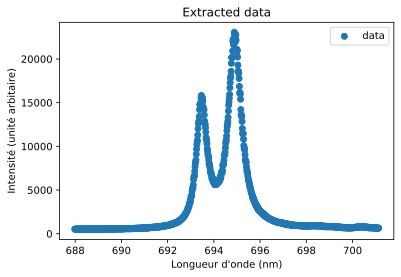

In [3]:
# on crée une figure :
plt.figure(1)

# on trace les données sous la forme d'un nuage de points, avec plt.scatter:
plt.scatter(x_data, y_data, label='data')

# On ajoute des étiquettes d'axe
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')

# On ajoute la légende, qui va indiqué le nom donné en "label" ci-dessus
plt.legend() 

# et un titre:
plt.title('Extracted data')

plt.show()

## Ajustement d'une fonction avec la fonction `curve_fit` de `scipy`

Nous allons réaliser un ajustement en utilisant deux fonctions *lorentziennes*. Il nous faut pour cela définir une fonction décrivant le profil lorentzien tel que : 
$$
\Large I(\nu) = \frac{A}{1 + \left(\frac{\nu-\nu_0}{\Gamma/2}\right)^2}
$$

où $A$ est hauteur (maximum) de la fonction, $\nu_0$ la position de ce maximum, et $\Gamma$ la largeur à mi-hauteur.

In [12]:
def lorentzian(x, A, x0, gamma):
    return A/(1 + ( (x-x0)/(gamma/2) )**2)

A partir de cette fonction, on peut définir un modèle pour représenter le spectre de luminescence du rubis comme la somme de deux fonction lorentzienne et d'une constante $c$ représentant le fond. 

In [13]:
def ruby_model(x, A1, x1, gamma1, A2, x2, gamma2, c):
    return lorentzian(x, A1, x1, gamma1) + lorentzian(x, A2, x2, gamma2) + c

On définit les paramètres initiaux pour le fit, puis on appelle la fonction [`curve_fit`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) pour réaliser l'ajustement :

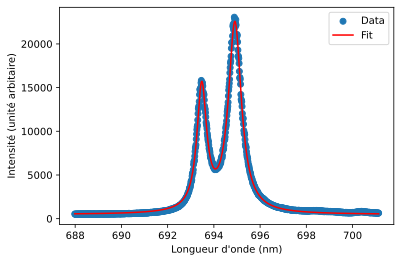

Optimized Parameters:
A1:     14100.697570947465
x1:     693.4760009771001
gamma1: 0.506415187477642
A2:     21688.05798297606
x2:     694.9096268317035
gamma2: 0.6788096374811154
c:      474.14708847288955


In [44]:
# les paramètres initiaux sont renseignés dans l'ordre défini ci-dessus dans la fonction ruby_model, tel que
# [A1, x1, gamma1, A2, x2, gamma2]
initial_guesses = [15000, 693.5, 0.5, 20000, 695, 0.5, 0]

# On réalise le fit :
# les paramètres optimisés sont stockés dans popt
# la matrice de covariance est stockée dans pcov:

popt, pcov = curve_fit(ruby_model, x_data, y_data, p0=initial_guesses)

# On trace les données brutes et le fit obtenu
plt.figure()
plt.scatter(x_data, y_data, label='Data')

plt.plot(x_data, ruby_model(x_data, *popt), color='red', label='Fit')
plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')
plt.legend()
plt.show()

# On affiche les paramètres obtenus
print("Optimized Parameters:")
print("A1:    ", popt[0])
print("x1:    ", popt[1])
print("gamma1:", popt[2])
print("A2:    ", popt[3])
print("x2:    ", popt[4])
print("gamma2:", popt[5])
print("c:     ", popt[6])


## Ajustement avec la bibliothèque `lmfit`

La bibliothèque `lmfit` permet de réaliser le même type d'ajustement. L'interface de fit est cependant différente, car `lmfit` possède déjà un grand nombre de [modèles pré-définis](https://lmfit.github.io/lmfit-py/builtin_models.html), tels que les lorentziennes, gaussiennes, Voigt, etc...  `lmfit` dispose également d'une série de fonctionnalités plus avancées et bien utiles, comme par exemple l'affichage d'un rapport détaillé du fit et des statistiques associées (voir ci-dessous). 

Nous allons ici créer un modèle `lmfit`, tel que la somme de deux lorentziennes et d'une constante :

[[Model]]
    ((Model(lorentzian, prefix='L1_') + Model(lorentzian, prefix='L2_')) + Model(constant))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 1024
    # variables        = 7
    chi-square         = 36050758.5
    reduced chi-square = 35448.1401
    Akaike info crit   = 10734.2219
    Bayesian info crit = 10768.7422
    R-squared          = 0.99838394
[[Variables]]
    L1_amplitude:  11217.3628 +/- 45.4596737 (0.41%) (init = 15000)
    L1_center:     693.476124 +/- 8.6991e-04 (0.00%) (init = 693.5)
    L1_sigma:      0.25322757 +/- 0.00134511 (0.53%) (init = 1)
    L2_amplitude:  23124.2052 +/- 54.5387260 (0.24%) (init = 20000)
    L2_center:     694.909633 +/- 6.5688e-04 (0.00%) (init = 695)
    L2_sigma:      0.33938549 +/- 0.00103802 (0.31%) (init = 1)
    c:             474.185179 +/- 7.32580811 (1.54%) (init = 0)
    L1_fwhm:       0.50645513 +/- 0.00269022 (0.53%) == '2.0000000*L1_sigma'
    L1_height:     14100.351

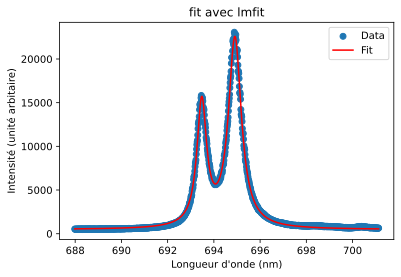

In [46]:
# On importe les fonctions nécessaires du module lmfit.models : 
from lmfit.models import LorentzianModel, ConstantModel

# On crée un modèle: la somme de deux LorentzianModel et d'un ConstantModel.
# on peut définir un prefixe pour chaque sous-fonction afin de les identifier ensuite par ce nom:
model = LorentzianModel(prefix='L1_') + LorentzianModel(prefix='L2_') + ConstantModel()

# On crée un jeu de paramètres initiaux et on renseigne des valeurs initiales :
params = model.make_params(L1_amplitude = 15000, 
                           L1_center = 693.5, 
                           L1_gamma1 = 0.5, 
                           L2_amplitude = 20000, 
                           L2_center = 695, 
                           L2_gamma1 = 0.5,
                           c = 0)  # Adjust initial guesses as per your data

# on effectue le fit. Les résultats seront stockés dans result
result = model.fit(y_data, params, x=x_data)

# On peut afficher un rapport détaillé du fit:
print(result.fit_report())

# On trace les données brutes et le fit obtenu
plt.figure()
plt.scatter(x_data, y_data, label='Data')

# il suffit ici d'appeler result.best_fit pour l'axe y :
plt.plot(x_data, result.best_fit, color='red', label='Fit')

plt.xlabel("Longueur d'onde (nm)")
plt.ylabel('Intensité (unité arbitaire)')
plt.legend()
plt.title('fit avec lmfit')
plt.show()

On peut afficher le résultat sous la forme d'un tableau contenant les différents paramètres obtenus ainsi que leurs erreurs statistiques :

In [50]:
result.params

name,value,standard error,relative error,initial value,min,max,vary,expression
L1_amplitude,11217.3628,45.4596737,(0.41%),15000.0,-inf,inf,True,
L1_center,693.476124,8.6991e-04,(0.00%),693.5,-inf,inf,True,
L1_sigma,0.25322757,0.00134511,(0.53%),1.0,0.00000000,inf,True,
L2_amplitude,23124.2052,54.5387260,(0.24%),20000.0,-inf,inf,True,
L2_center,694.909633,6.5688e-04,(0.00%),695.0,-inf,inf,True,
L2_sigma,0.33938549,0.00103802,(0.31%),1.0,0.00000000,inf,True,
c,474.185179,7.32580811,(1.54%),0.0,-inf,inf,True,
L1_fwhm,0.50645513,0.00269022,(0.53%),2.0,-inf,inf,False,2.0000000*L1_sigma
L1_height,14100.3512,48.0738480,(0.34%),4774.648499999999,-inf,inf,False,"0.3183099*L1_amplitude/max(1e-15, L1_sigma)"
L2_fwhm,0.67877097,0.00207603,(0.31%),2.0,-inf,inf,False,2.0000000*L2_sigma
